In [47]:
# imports libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import holidays

%matplotlib inline

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
us_holidays = holidays.US()

In [8]:
# build list of date strings, formatted for MTA's file naming convention
week_nums = []
start_date = pd.to_datetime("09/22/2018")
for i in range(0, 39):
    datestring = start_date.strftime('%y%m%d')
    week_nums.append(datestring)
    start_date = start_date - timedelta(days=7)

In [9]:
print(week_nums)

['180922', '180915', '180908', '180901', '180825', '180818', '180811', '180804', '180728', '180721', '180714', '180707', '180630', '180623', '180616', '180609', '180602', '180526', '180519', '180512', '180505', '180428', '180421', '180414', '180407', '180331', '180324', '180317', '180310', '180303', '180224', '180217', '180210', '180203', '180127', '180120', '180113', '180106', '171230']


In [10]:
# save MTA turnstile data for selected dates to dataframe "df"
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
df = get_data(week_nums)

In [13]:
print("Data loaded!")

Data loaded!


In [14]:
# date modifications and enhancements
df['DATETIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])
df['DATE'] = pd.to_datetime(df['DATETIME'].dt.date)
df['HOUR'] = df['DATETIME'].dt.hour
df['AMPM'] = np.where(df['HOUR']>=12, 'PM', 'AM')
df.columns = [column.strip() for column in df.columns]

In [15]:
print("Dates modified.")

Dates modified.


In [19]:
# sort LINENAME field alphanumerically
# clean up LINENAME for STATIONs with data issues
df['LINENAME'] = df['LINENAME'].apply(lambda x: ''.join(sorted(x)))
df['LINENAME'] = np.where(df['STATION'] == "TIMES SQ-42 ST", '1237ACENQRSW', df['LINENAME'])
df['LINENAME'] = np.where(df['STATION'] == "59 ST", '456NQRW', df['LINENAME'])
df['LINENAME'] = np.where(df['STATION'] == "34 ST-PENN STA", '123ACE', df['LINENAME'])

In [20]:
#df.groupby(["STATION", "LINENAME"]).size().reset_index(name="Time")
print("Lines modified.")

Lines modified.


In [21]:
# create filter mask to only check dates in 2018 between [5am, 12pm) and [4pm, 11pm)
mask = ((df["DATETIME"].dt.year == 2018) & \
        (((df["HOUR"] >= 5) & (df["HOUR"] < 12)) | \
             ((df["HOUR"] >= 16) & (df["HOUR"] < 23))))
df_mask = df[mask]

In [22]:
# group all data so that each station/date is sorted correctly for entries/exits calculations
df_daily = (df_mask
            .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","DATE", "AMPM", "EXITS"],as_index=False)
            .ENTRIES.first())

In [23]:
# iterate through df_daily to associate each day with previous day's entries/exits
# remove entries with no values to compare (first dates of chosen time period)
df_daily[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df_daily
                                           .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME","AMPM"])["DATE", "ENTRIES", "EXITS"]
                                           .apply(lambda grp: grp.shift(1)))
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [24]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,AMPM,EXITS,ENTRIES,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,456NQRW,2018-01-01,AM,2188106,6464517,2018-01-01,6464491.0,2188064.0
3,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,AM,2188247,6464934,2018-01-01,6464517.0,2188106.0
4,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,AM,2188505,6465085,2018-01-02,6464934.0,2188247.0
5,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,PM,2188659,6466098,2018-01-01,6464806.0,2188192.0
6,A002,R051,02-00-00,59 ST,456NQRW,2018-01-03,AM,2188747,6466420,2018-01-02,6465085.0,2188505.0


In [25]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,AMPM,EXITS,ENTRIES,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,456NQRW,2018-01-01,AM,2188106,6464517,2018-01-01,6464491.0,2188064.0
3,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,AM,2188247,6464934,2018-01-01,6464517.0,2188106.0
4,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,AM,2188505,6465085,2018-01-02,6464934.0,2188247.0
5,A002,R051,02-00-00,59 ST,456NQRW,2018-01-02,PM,2188659,6466098,2018-01-01,6464806.0,2188192.0
6,A002,R051,02-00-00,59 ST,456NQRW,2018-01-03,AM,2188747,6466420,2018-01-02,6465085.0,2188505.0


In [26]:
# calculate DAILY ENTRIES, reversing counters that are counting backwards and removing entries over 20k
def calc_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter    

df_daily["DAILY_ENTRIES"] = df_daily.apply(calc_daily_entries, axis=1, max_counter=20000)

In [27]:
# calculate DAILY EXITS, reversing counters that are counting backwards and removing exits over 20k
def calc_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter    

df_daily["DAILY_EXITS"] = df_daily.apply(calc_daily_exits, axis=1, max_counter=20000)

In [28]:
# group all data by CONTROL AREA, aggregating all turnstile (SCP) data 
df_daily_ca = (df_daily
      .groupby(['C/A', 'STATION', 'LINENAME','DATE', "AMPM"])['DAILY_ENTRIES', 'DAILY_EXITS']
      .mean()
      .reset_index()         
     )

df_daily_ca.rename(columns = {'DAILY_ENTRIES':'ENTRIES', 'DAILY_EXITS':'EXITS'}, inplace=True)
df_daily_ca.head()

,C/A,STATION,LINENAME,DATE,AMPM,ENTRIES,EXITS
0,A002,59 ST,456NQRW,2018-01-01,AM,37.300000,53.100000
1,A002,59 ST,456NQRW,2018-01-02,AM,285.500000,267.772727
2,A002,59 ST,456NQRW,2018-01-02,PM,935.083333,612.083333
3,A002,59 ST,456NQRW,2018-01-03,AM,591.318182,369.590909
4,A002,59 ST,456NQRW,2018-01-03,PM,1116.750000,687.333333


In [29]:
# mask all CONTROL AREAS with 0 entries or 0 exits
df_daily_ca['ENTRIES'].value_counts()
mask2 = ((df_daily_ca["ENTRIES"] != 0) & (df_daily_ca["EXITS"] != 0))
df_daily_ca_mask = df_daily_ca[mask2]

In [41]:
# Source NOAA weather data for Central Park from Jan 2010 to Sept 2018
#Source: https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail
weather = pd.read_csv('1478658.csv')

In [48]:
# add date modifications and classifications
# add RAINY and SNOWY threshold classifications
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['YEAR'] = weather["DATE"].dt.year
weather['RAINY'] = np.where(weather['PRCP']>=1, True, False)
weather['SNOWY'] = np.where(weather['SNOW']>=3, True, False)
weather['WEEKDAY'] = np.where(weather['DATE'].dt.weekday < 5, True, False)
weather['HOLIDAY'] = weather['DATE'].isin(us_holidays)
weather.reset_index()
weather.head()


,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,YEAR,RAINY,SNOWY,WEEKDAY,HOLIDAY
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-01,0.03,0.0,0.0,NaN,40,33,2010,False,False,True,False
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-02,0.02,0.2,0.0,NaN,34,17,2010,False,False,False,False
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-03,0.00,0.0,0.0,NaN,22,17,2010,False,False,False,False
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-04,0.00,0.0,0.0,NaN,30,19,2010,False,False,True,False
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-05,0.00,0.0,0.0,NaN,30,20,2010,False,False,True,False


In [49]:
# check RAINY data for 2018 to ensure thresholds are appropriate
weather2018 = weather.loc[weather['YEAR'] == 2018]
rainiest = weather2018.loc[weather2018['RAINY'] == True]
rainiest = rainiest.sort_values(['DATE'], ascending=[False])
rainiest.shape


(10, 14)

In [50]:
# check SNOWY data for 2018 to ensure thresholds are appropriate
snowiest = weather2018.loc[weather2018['SNOWY'] == True]
snowiest = snowiest.sort_values(['SNOW'], ascending=[False])
snowiest.shape

(5, 14)

In [51]:
# merge MTA data with NOAA data to append RAINY/WEEKDAY/HOLIDAY info
# filter for only AM data
result = pd.merge(df_daily_ca_mask, 
                  weather[['DATE', 'RAINY', 'WEEKDAY', 'HOLIDAY']], 
                  on='DATE', how="left")             
result = result[result['AMPM'] == "AM"]

In [52]:
# RESULT GROUP BY #1
# group by all variables except DATE
# remove weekends and holidays
# add RATIO data
result_gb = (result
             .groupby(['WEEKDAY', 'HOLIDAY', 'AMPM', 'RAINY','C/A', 'STATION', 'LINENAME'])['ENTRIES', 'EXITS']
             .agg({'ENTRIES' : 'mean', 'EXITS' : 'mean', 'DATE' : 'count'})
             .reset_index()
     )
result_gb.rename(columns = {'DATE':'DAYCOUNT'}, inplace=True)
result_gb = result_gb[result_gb['WEEKDAY'] == True]
result_gb = result_gb[result_gb['HOLIDAY'] == False]
result_gb["ENTRIES_EXITS_RATIO"] = result_gb["ENTRIES"] / result_gb["EXITS"] 
result_gb["RATING"] = ((10000 / result_gb["ENTRIES"]) * result_gb["ENTRIES_EXITS_RATIO"]**2).astype(int)

/Users/brendonhapp/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [53]:
# RESULT GROUP BY #2
# group by all variables except DATE and RAINY (MIXED WEATHER)
# remove weekends and holidays
# add RATIO data
result_gb2 = (result
             .groupby(['WEEKDAY', 'HOLIDAY', 'AMPM', 'C/A', 'STATION', 'LINENAME'])['ENTRIES', 'EXITS']
             .agg({'ENTRIES' : 'mean', 'EXITS' : 'mean', 'DATE' : 'count'})
             .reset_index()
     )
result_gb2.rename(columns = {'DATE':'DAYCOUNT'}, inplace=True)
result_gb2 = result_gb2[result_gb2['WEEKDAY'] == True]
result_gb2 = result_gb2[result_gb2['HOLIDAY'] == False]
result_gb2["ENTRIES_EXITS_RATIO"] = result_gb2["ENTRIES"] / result_gb2["EXITS"] 
result_gb2["RATING"] = (10000 / result_gb2["ENTRIES"]) * result_gb2["ENTRIES_EXITS_RATIO"]**2


/Users/brendonhapp/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [54]:
# RESULT GROUP BY #3
# group by all variables except DATE, RAINY (MIXED WEATHER), and AMPM
# remove weekends and holidays
# add RATIO data
result_gb3 = (result
             .groupby(['WEEKDAY', 'HOLIDAY', 'C/A', 'STATION', 'LINENAME'])['ENTRIES', 'EXITS']
             .agg({'ENTRIES' : 'mean', 'EXITS' : 'mean', 'DATE' : 'count'})
             .reset_index()
     )
result_gb3.rename(columns = {'DATE':'DAYCOUNT'}, inplace=True)
result_gb3 = result_gb3[result_gb3['WEEKDAY'] == True]
result_gb3 = result_gb3[result_gb3['HOLIDAY'] == False]
result_gb3["ENTRIES_EXITS_RATIO"] = result_gb3["ENTRIES"] / result_gb3["EXITS"] 
result_gb3["RATING"] = (10000 / result_gb3["ENTRIES"]) * result_gb3["ENTRIES_EXITS_RATIO"]**2

/Users/brendonhapp/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [55]:
# RESULT ALL
# return all fields
# remove weekends and holidays
# add RATIO data

result = result[result['WEEKDAY'] == True]
result = result[result['HOLIDAY'] == False]
result["ENTRIES_EXITS_RATIO"] = result["ENTRIES"] / result["EXITS"] 
result["RATING"] = (10000 / result["ENTRIES"]) * result["ENTRIES_EXITS_RATIO"]**2

In [56]:
sns.set()

In [57]:
# create various masks to graph specific STATION data
mask_grand = (result["STATION"] == "GRD CNTRL-42 ST")
result_grand = result[mask_grand]
mask_fulton = ((result["STATION"] == "FULTON ST") & (result["LINENAME"] != "G"))
result_fulton = result[mask_fulton]
mask_times = (result["STATION"] == "TIMES SQ-42 ST")
result_times = result[mask_times]
mask_union = (result["STATION"] == "14 ST-UNION SQ")
result_union = result[mask_union]
mask_penn = (result["STATION"] == "34 ST-PENN STA")
result_penn = result[mask_penn]
mask_herald = (result["STATION"] == "34 ST-HERALD SQ")
result_herald = result[mask_herald]

## graph section

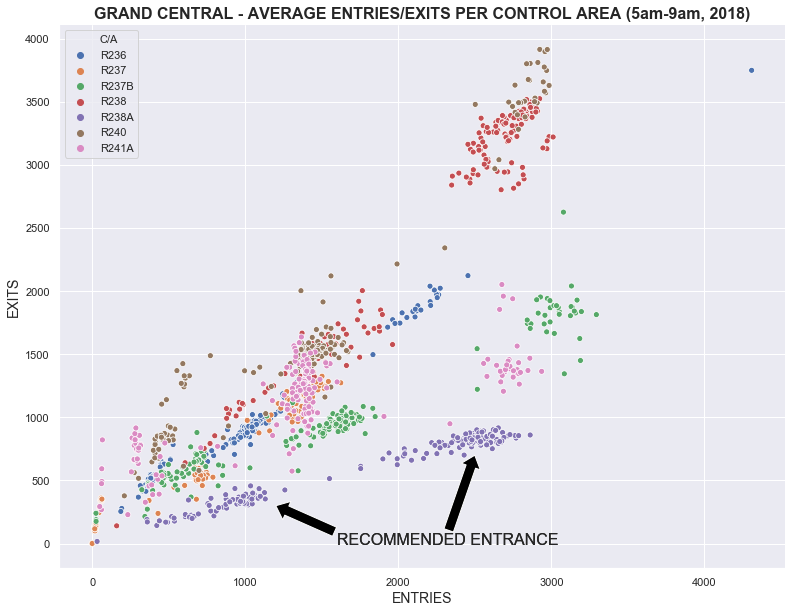

In [58]:
# GRAND CENTRAL SCATTER PLOT
plt.figure(figsize=(13,10))
plt.annotate('RECOMMENDED ENTRANCE', xy=(1200,300), xytext=(1600, -10), fontsize=16,
            arrowprops=dict(facecolor='black', headwidth=20,width=10),
            )
plt.annotate('RECOMMENDED ENTRANCE', xy=(2500,700), xytext=(1600, -10), fontsize=16,
            arrowprops=dict(facecolor='black', headwidth=20,width=10),
            )
sns_plot = sns.scatterplot(x="ENTRIES", y="EXITS", data=result_grand, hue='C/A', legend='full')
plt.title("GRAND CENTRAL - AVERAGE ENTRIES/EXITS PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
plt.xlabel('ENTRIES', fontsize=14)
plt.ylabel('EXITS', fontsize=14)
figure = sns_plot.get_figure()   
sns.set_style(None)
sns.despine()
figure.savefig('grand_cent_av_ca.png', dpi=400)


In [298]:
# # FULTON STREET SCATTER PLOT
# plt.figure(figsize=(10,10))
# plt.annotate('RECOMMENDED ENTRANCE', xy=(350,0), xytext=(750, -10), fontsize=16,
#             arrowprops=dict(facecolor='black', headwidth=20,width=10),
#             )
# sns_plot = sns.scatterplot(x="ENTRIES", y="EXITS", data=result_fulton, hue='C/A', legend='full')
# plt.title("FULTON ST - AVERAGE ENTRIES/EXITS PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
# plt.xlabel('ENTRIES', fontsize=14)
# plt.ylabel('EXITS', fontsize=14)
# figure = sns_plot.get_figure()    
# figure.savefig('FULTON-AM-Mixed-Scatter-Large.png', dpi=400)

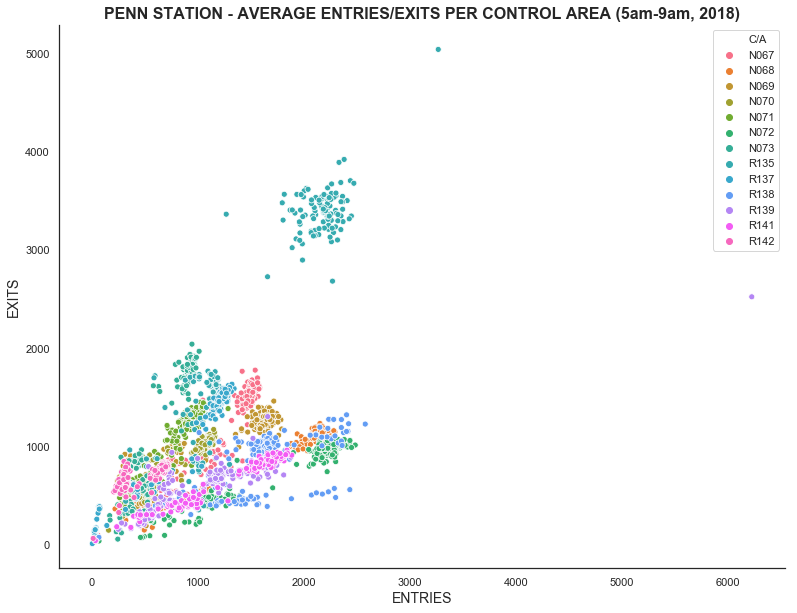

In [303]:
# HERALD SQUARE SCATTER PLOT
# plt.figure(figsize=(13,10))
#plt.annotate('RECOMMENDED ENTRANCE', xy=(1200,300), xytext=(1600, -10), fontsize=16,
#             arrowprops=dict(facecolor='black', headwidth=20,width=10),
#             )
# plt.annotate('RECOMMENDED ENTRANCE', xy=(2500,700), xytext=(1600, -10), fontsize=16,
#             arrowprops=dict(facecolor='black', headwidth=20,width=10),
#             )
# sns_plot = sns.scatterplot(x="ENTRIES", y="EXITS", data=result_penn, hue='C/A', legend='full')
# plt.title("PENN STATION - AVERAGE ENTRIES/EXITS PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
# plt.xlabel('ENTRIES', fontsize=14)
# plt.ylabel('EXITS', fontsize=14)
# figure = sns_plot.get_figure()   
# sns.set_style(None)
# sns.despine()
# figure.savefig('PENN-AM-Mixed-Scatter-Large.png', dpi=400)

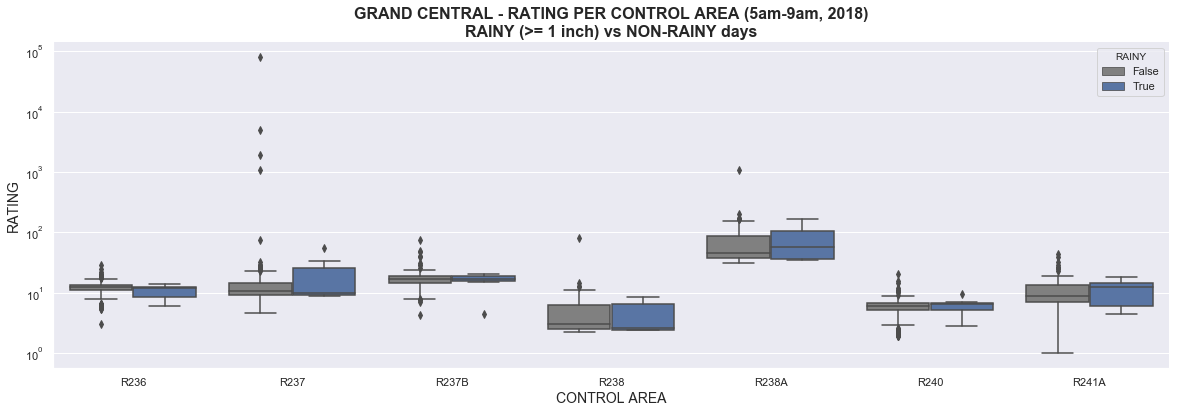

In [59]:
# GRAND CENTRAL BOX PLOT (RAINY)
plt.subplots(figsize=(20,6))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_grand)
plt.title("GRAND CENTRAL - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
# plt.figure(facecolor="w")
figure = sns_plot.get_figure()   
sns.despine()
sns.set_style("white")
# figure = plt.figure(facecolor="w")
figure.savefig('GRAND-AM-Rainy-Box-Large.png', dpi=400)

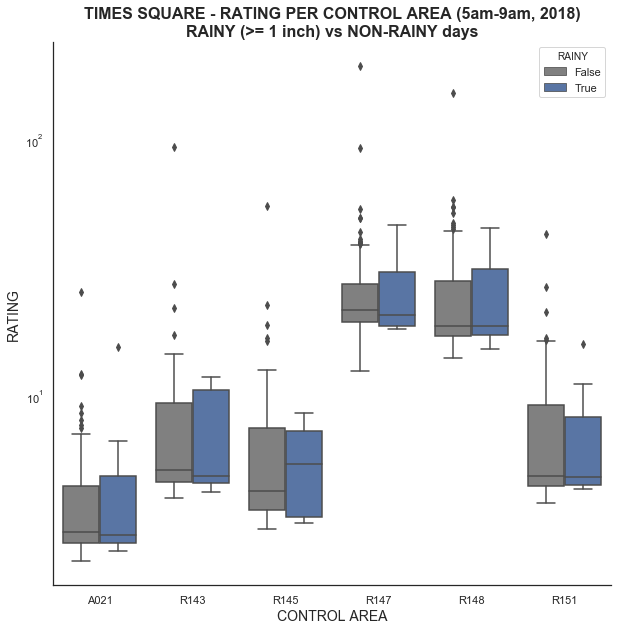

In [284]:
# TIMES SQUARE BOX PLOT (RAINY)
plt.subplots(figsize=(10,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_times)
plt.title("TIMES SQUARE - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('TIMES-AM-Rainy-Box-Large.png', dpi=400)

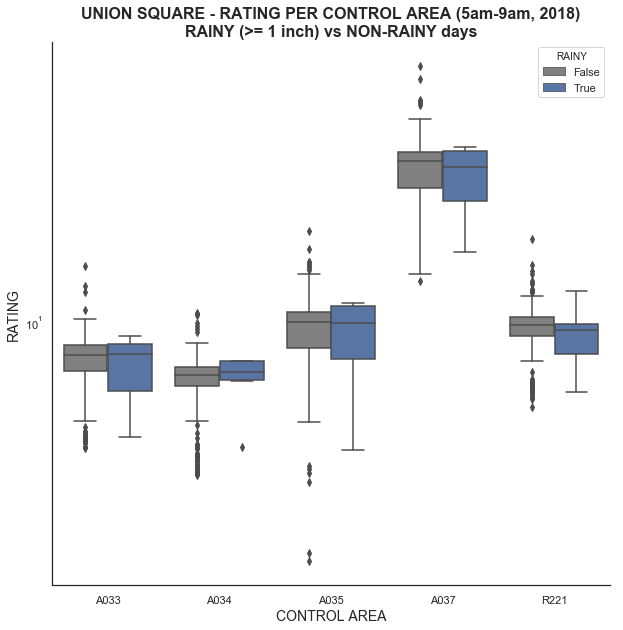

In [285]:
# UNION SQUARE BOX PLOT (RAINY)
plt.subplots(figsize=(10,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_union)
plt.title("UNION SQUARE - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('UNION-AM-Rainy-Box-Large.png', dpi=400)

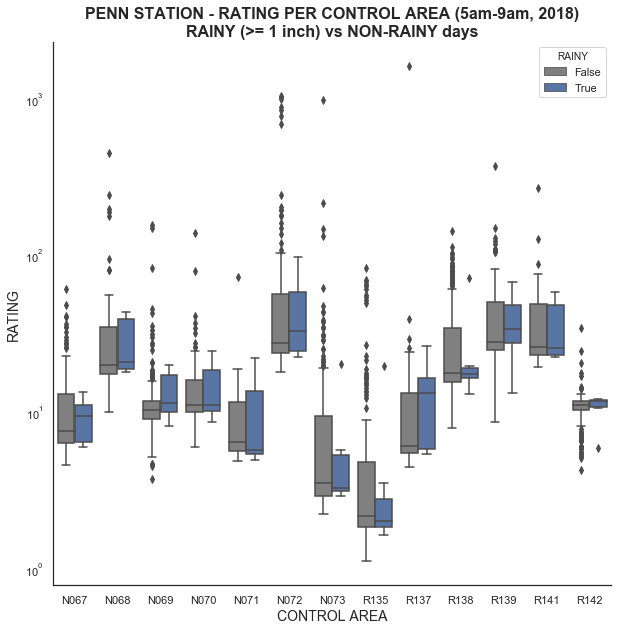

In [293]:
# PENN STATION BOX PLOT (RAINY)
plt.subplots(figsize=(10,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_penn)
plt.title("PENN STATION - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('PENN-AM-Rainy-Box-Large.png', dpi=400)

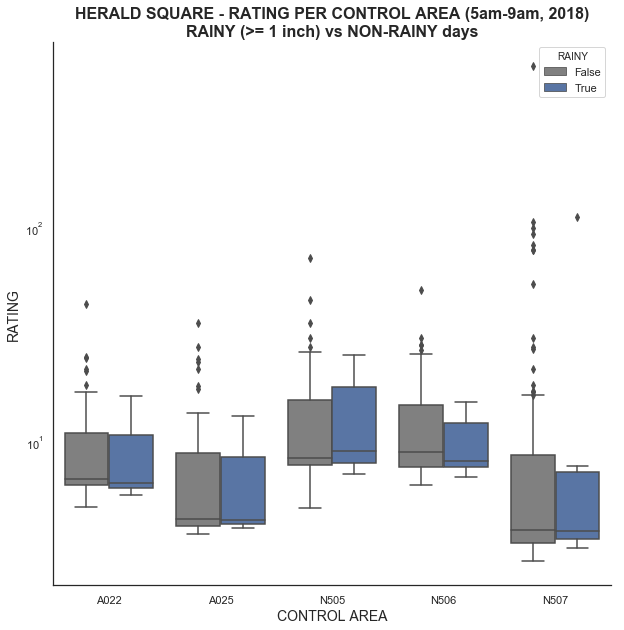

In [300]:
# HERALD SQUARE BOX PLOT (RAINY)
plt.subplots(figsize=(10,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_herald)
plt.title("HERALD SQUARE - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('HERALD-AM-Rainy-Box-Large.png', dpi=400)

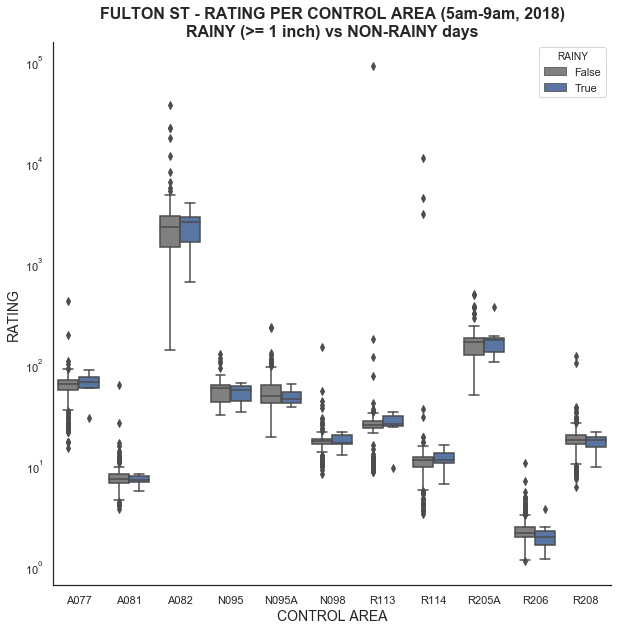

In [286]:
# FULTON ST BOX PLOT (RAINY)
plt.subplots(figsize=(10,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            hue="RAINY", palette=["gray", "b"],
            data=result_fulton)
plt.title("FULTON ST - RATING PER CONTROL AREA (5am-9am, 2018)\nRAINY (>= 1 inch) vs NON-RAINY days", \
          fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('FULTON-AM-Rainy-Box-Large.png', dpi=400)

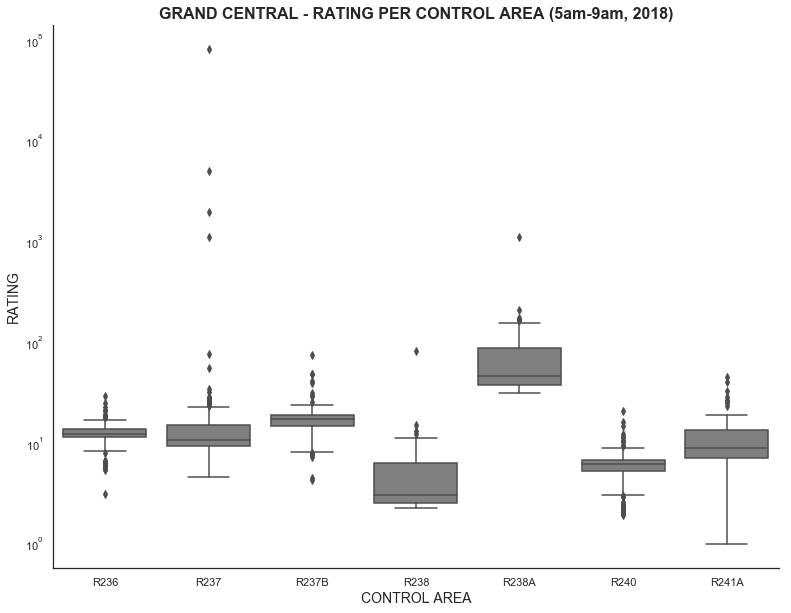

In [60]:
# GRAND CENTRAL BOX PLOT (MIXED)
plt.subplots(figsize=(13,10))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            color="gray",
            data=result_grand)
plt.title("GRAND CENTRAL - RATING PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('GRAND-AM-Mixed-Box-Large.png', dpi=400)


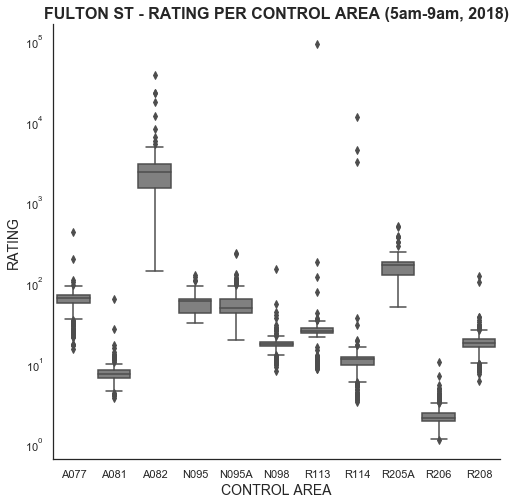

In [61]:
# FULTON ST BOX PLOT (MIXED)
plt.subplots(figsize=(8,8))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            color="gray",
            data=result_fulton)
plt.title("FULTON ST - RATING PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('FULTON-AM-Mixed-Box-Large.png', dpi=400)


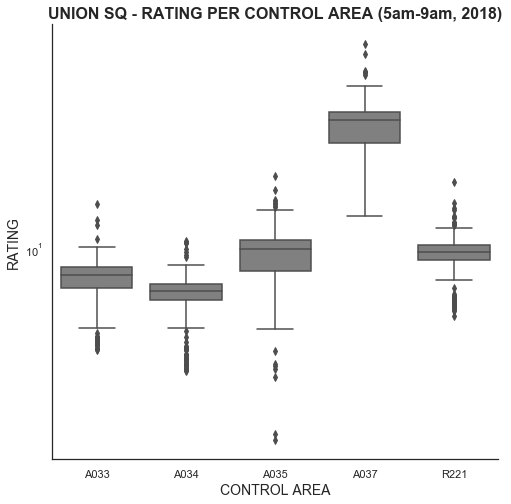

In [62]:
# UNION SQ BOX PLOT (MIXED)
plt.subplots(figsize=(8,8))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            color="gray",
            data=result_union)
plt.title("UNION SQ - RATING PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('UNION-AM-Mixed-Box-Large.png', dpi=400)

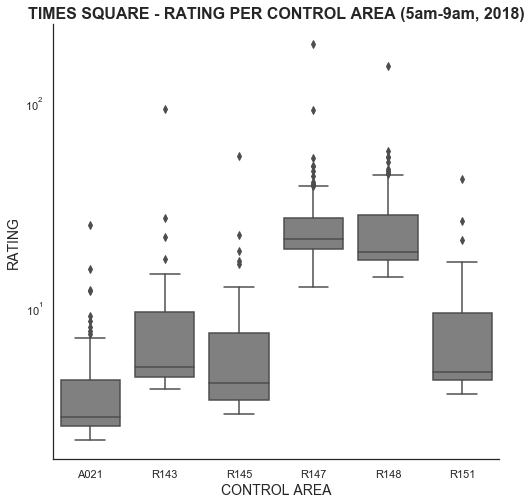

In [63]:
# TIMES SQUARE BOX PLOT (MIXED)
plt.subplots(figsize=(8,8))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            color="gray",
            data=result_times)
plt.title("TIMES SQUARE - RATING PER CONTROL AREA (5am-9am, 2018)", fontsize=16, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('TIMES-AM-Mixed-Box-Large.png', dpi=400)

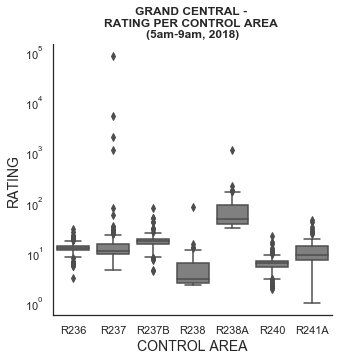

In [64]:
# GRAND CENTRAL BOX PLOT (MIXED) - SMALL 
plt.subplots(figsize=(5,5))
plt.yscale("log")
sns_plot = sns.boxplot(x="C/A", y="RATING",
            color="gray",
            data=result_grand)
plt.title("GRAND CENTRAL - \nRATING PER CONTROL AREA \n(5am-9am, 2018)", fontsize=12, fontweight='bold')
plt.xlabel('CONTROL AREA', fontsize=14)
plt.ylabel('RATING', fontsize=14)
sns.despine()
sns.set_style("white")
figure = sns_plot.get_figure()    
figure.savefig('GRAND-AM-Mixed-Box-Small.png', dpi=400)

## All code below was used to fix LINENAME issues


In [258]:
# df_station = df.groupby(["STATION", "LINENAME", "DIVISION"]).size().reset_index(name="Time")
# df_station

In [250]:
# df_daily_ca_mask.head(100)

In [251]:
# result.head(100)

In [252]:
# station_fix = (df_station.groupby
#                (["STATION", "DIVISION"])
#                .agg({"LINENAME": "nunique"})
#               .reset_index()
#               )
# station_fix.head()

In [253]:
# station_problems = station_fix[station_fix["LINENAME"] > 1]
# station_problems

In [254]:
# station_problem_detail = pd.merge(station_problems, 
#                   df_station[['STATION', 'LINENAME', 'DIVISION']], 
#                   on='STATION', how="left") 

# station_problem_detail.shape
                                    

In [337]:
result.head()

,C/A,STATION,LINENAME,DATE,AMPM,ENTRIES,EXITS,RAINY,WEEKDAY,HOLIDAY,ENTRIES_EXITS_RATIO,RATING
0,A002,59 ST,456NQRW,2018-01-01,AM,37.300000,53.100000,False,True,False,0.702448,132.287799
1,A002,59 ST,456NQRW,2018-01-02,AM,285.500000,267.772727,False,True,False,1.066203,39.817449
3,A002,59 ST,456NQRW,2018-01-03,AM,591.318182,369.590909,False,True,False,1.599926,43.289112
5,A002,59 ST,456NQRW,2018-01-04,AM,449.758621,247.137931,False,True,False,1.819869,73.637779
7,A002,59 ST,456NQRW,2018-01-05,AM,406.272727,288.363636,False,True,False,1.408890,48.858112


## All code below was used to find the rainiest stations - it was not used

In [374]:
result_rain = (result_gb
             .groupby(["STATION", "LINENAME","C/A", "RAINY","AMPM"])['RATING']
             .mean()
             .reset_index()
     )
result_rain.head()

,STATION,LINENAME,C/A,RAINY,AMPM,RATING
0,1 AV,L,H007,False,AM,10
1,1 AV,L,H007,True,AM,12
2,1 AV,L,H008,False,AM,2
3,1 AV,L,H008,True,AM,2
4,103 ST,1,R170,False,AM,35


In [375]:
result_rain[["PREV_WEATHER", "RAINY_RATING", "DRY_RATING"]] = (result_rain
                             .groupby(["STATION", "LINENAME","C/A","AMPM"])["RAINY", "RATING"]
                             .apply(lambda grp: grp.shift(1))
                             .reset_index()
                            )
result_rain.dropna(subset=["DRY_RATING"], axis=0, inplace=True)
result_rain["RAIN_EFFECT"] = ((result_rain["DRY_RATING"] - result_rain["RATING"]) / result_rain["RATING"])

In [383]:
result_rain.sort_values(["RAIN_EFFECT"], ascending=False).head(70)

,STATION,LINENAME,C/A,RAINY,AMPM,RATING,PREV_WEATHER,RAINY_RATING,DRY_RATING,RAIN_EFFECT
1234,NEWARK HM HE,1,PTH20,True,AM,0,1234,False,1.0,inf
1264,ORCHARD BEACH,6,OB01,True,AM,347,1264,False,11071.0,30.904899
1230,NEWARK BM BW,1,PTH18,True,AM,431,1230,False,2238.0,4.192575
604,AVENUE I,F,N551,True,AM,124,604,False,518.0,3.177419
610,AVENUE N,F,N554,True,AM,4040,610,False,8154.0,1.018317
988,FULTON ST,2345ACJZ,R206,True,AM,1,988,False,2.0,1.000000
614,AVENUE P,F,N556,True,AM,377,614,False,632.0,0.676393
249,238 ST,1,R196,True,AM,5341,249,False,8542.0,0.599326
834,CORTLANDT ST,1,R108,True,AM,65,834,False,103.0,0.584615
550,86 ST,R,C026,True,AM,462,550,False,728.0,0.575758


In [360]:
result_rain.tail()

,STATION,LINENAME,C/A,RAINY,AMPM,RATING,PREV_WEATHER,RAINY_RATING,DRY_RATING,RAIN_EFFECT
1484,WOODHAVEN BLVD,MR,N329A,True,AM,1569,1484,False,1662.0,-93.0
1486,WOODLAWN,4,R294,True,AM,165,1486,False,178.0,-13.0
1488,WORLD TRADE CTR,23ACE,N094,True,AM,20,1488,False,20.0,0.0
1490,YORK ST,F,N530,True,AM,32,1490,False,32.0,0.0
1492,ZEREGA AV,6,R419,True,AM,40,1492,False,45.0,-5.0


In [ ]:
result_rain['RAIN_EFFECT'].value_counts()